In [ ]:
!pip install mesa==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.4/263.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 18

In [ ]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install colab-xterm #https://pypi.org/project/colab-xterm/

In [ ]:
%pip install -U langchain-ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.0
    Uninstalling httpx-0.28.0:
      Successfully uninstalled httpx-0.28.0


In [ ]:
from mesa import Agent
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from mesa import Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import pandas as pd
from huggingface_hub import login
import warnings
from transformers import pipeline

### Hugging Face

In [ ]:
login("token")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Setting `pad_token_id`")

### Ollama

In [ ]:
%load_ext colabxterm

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
!ollama list

NAME               ID              SIZE      MODIFIED      
llama3.2:latest    a80c4f17acd5    2.0 GB    2 seconds ago    


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

### ToT (you need to add it to class Prisoner in order to actually run it)

In [ ]:
def step(self):
    """
    The agent's step function with Tree of Thoughts (ToT) for decision-making.
    """
    # Define the initial question for the LLM
    initial_question = '''Will you choose Cooperate or Betray this round? Your answer MUST be either Cooperate or Betray. Your answer MUST be just one word!'''

    # Step 1: Generate multiple thoughts for each possible action
    thoughts_prompt = (
        self.game_prompt + self.history + f"""
        {initial_question}

        Now, before making a decision, think step-by-step about the possible outcomes.
        - Generate reasons for cooperating, reflecting on game history and the opponent's patterns.
        - Generate reasons for betraying, reflecting on game history and the opponent's patterns.
        After exploring, choose the best action.
        """
    )

    # Generate thoughts for each option
    thoughts_response = self.llm_model.invoke({"question": thoughts_prompt})

    # Step 2: Extract and evaluate thoughts
    thoughts = self.extract_thoughts(thoughts_response)

    # Simulate outcomes for each thought
    outcomes = []
    for thought in thoughts:
        simulation_prompt = self.game_prompt + self.history + f"""
        Suppose you choose to "{thought['action']}".
        - How might your opponent respond based on their previous behavior?
        - What would your score and theirs likely be?
        Use this information to refine your decision-making.
        """
        simulated_response = self.llm_model.invoke({"question": simulation_prompt})
        outcome = self.evaluate_simulated_response(simulated_response)
        outcomes.append({"action": thought['action'], "outcome": outcome})

    # Step 3: Select the best action
    best_decision = max(outcomes, key=lambda x: x['outcome']['score'])
    self.decision = best_decision['action']

    # Store the response for logging/debugging
    self.response = f"Thoughts: {thoughts}, Best Decision: {self.decision}"

    # Helper to extract the final one-word decision
    self.response = self.extract_response(self.decision)

def extract_thoughts(self, response):
    """
    Extracts individual thoughts from the LLM's response.
    """
    thoughts = []
    # Parse response to extract arguments for Cooperate and Betray
    if "cooperate" in response.lower():
        thoughts.append({"action": "Cooperate", "reason": response})
    if "betray" in response.lower():
        thoughts.append({"action": "Betray", "reason": response})
    return thoughts

def evaluate_simulated_response(self, response):
    """
    Parses the LLM's simulation response to extract expected outcomes.
    """
    # Extract numerical evaluation (e.g., scores or utility)
    if "score" in response.lower():
        # Parse scores for the player and opponent
        try:
            player_score = float(re.search(r"Your score: (\d+)", response).group(1))
            opponent_score = float(re.search(r"Opponent's score: (\d+)", response).group(1))
            return {"score": player_score - opponent_score, "details": response}
        except:
            return {"score": 0, "details": response}
    return {"score": 0, "details": response}


### Prisoner Class

In [ ]:
class Prisoner(Agent):
    """An agent representing a prisoner in the Prisoner's Dilemma."""

    def __init__(self, unique_id, model, game_prompt, personality, llm_model, history=""):
        super().__init__(unique_id, model)


        self.game_prompt = game_prompt
        self.personality = personality
        self.history = history
        self.score = 0.0
        self.decision = None
        self.response = None
        self.llm_model = llm_model
        self.game_history = {'my_choices':{}, 'opponents_choices':{}}

        # Load an instruction-tuned LLaMA variant from Hugging Face
        # self.tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/mistral-7b-anthropic")
        # self.llm_model = AutoModelForCausalLM.from_pretrained("HuggingFaceH4/mistral-7b-anthropic")#.to("cuda")

        # Load an instruction-tuned LLaMA variant from Hugging Face
        #self.generator = pipeline("text-generation", model='meta-llama/Llama-3.2-3B-Instruct', device=0)  # Use device=0 to run on GPU if available


    def step(self):
        """
        The agent's step function.
        """
        # Construct the prompt with personality and history
        # template = f"""You are a person with the following Big Five personality traits:
        #             You are {self.personality['Openness']} in trait 'openness'.
        #             You are {self.personality['Conscientiousness']} in trait 'conscientiousness'.
        #             You are {self.personality['Extraversion']} in trait 'extraversion'.
        #             You are {self.personality['Agreeableness']} in trait 'agreeableness'.
        #             You are {self.personality['Neuroticism']} in trait 'neuroticism'.
        #             - Act coherently with your personality traits.
        #             """ +
        template = self.game_prompt + self.history + '''
                    {{question}}
                    Will you choose Cooperate or Betray this round? Your answer MUST be either Cooperate or Betray. Your answer MUST be just one word!'''


        prompt = ChatPromptTemplate.from_template(template)

        chain = prompt | self.llm_model

        # print(template)

        self.decision = chain.invoke({"question": '''Will you choose Cooperate or Betray this round? Your answer MUST be either Cooperate or Betray. Your answer MUST be just one word!'''})
        self.response = self.extract_response(self.decision)

        # print(self.decision)
        # print(self.response)


        #Hugging Face
        # response = self.generator(prompt, max_new_tokens = 100, temperature=1, top_p=0.9, top_k=50, num_return_sequences=1)

        # self.response = response[0]["generated_text"][len(prompt):]
        # self.decision = self.extract_response(self.response)

        # print(response)


        # # Specify pad token id if needed
        # self.tokenizer.pad_token = self.tokenizer.eos_token  # Set pad_token as eos_token
        # self.llm_model.config.pad_token_id = self.tokenizer.pad_token_id  # Ensure the model is aware of this

        # # Tokenize and generate a response using the model
        # inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True) #.to("cuda")

        # # Ensure model generates response on CUDA
        # with torch.no_grad():
        #     # Generate the continuation of the prompt
        #     outputs = self.llm_model.generate(
        #                     inputs['input_ids'],            # The tokenized prompt
        #                     temperature=1,                # Control randomness
        #                     attention_mask=inputs['attention_mask'],  # Ensure attention mask is passed
        #                     eos_token_id=self.tokenizer.eos_token_id,  # Set end-of-sequence token
        #                     max_length=512
        #                 )

        # # Decode the generated response (keep on CPU for compatibility with tokenizer)
        # response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # self.response = response[len(prompt):]
        # self.decision = self.extract_response(response)

        # print(response)


    def update_score(self, other_prisoner_decision, rewards):
        """
        Updates the prisoner's score based on their decision and the other prisoner's decision.
        """
        if "cooperate" in self.decision.lower() and "cooperate" in other_prisoner_decision.lower():
            self.score += float(rewards[0])  # Both cooperate
        elif "betray" in self.decision.lower() and "betray" in other_prisoner_decision.lower():
            self.score += float(rewards[1])  # Both betray
        elif "betray" in self.decision.lower() and "cooperate" in other_prisoner_decision.lower():
            self.score += float(rewards[3])  # This prisoner betrays, the other cooperates
        elif "cooperate" in self.decision.lower() and "betray" in other_prisoner_decision.lower():
            self.score += float(rewards[2])  # This prisoner cooperates, the other betrays


    def update_history(self, round, other_prisoner_decision, opponent_points, current_supergame):
        """
        Updates the prisoner's history with the outcome of the current round.
        """

        # Process self decision
        decision_lower = self.decision.lower()
        if 'cooperate' in decision_lower:
            decision_to_add = 'C'
        elif 'betray' in decision_lower:
            decision_to_add = 'B'
        else:
            decision_to_add = ''

        if current_supergame not in self.game_history:
            self.game_history['my_choices'][current_supergame] = ''
        else:
            self.game_history['my_choices'][current_supergame] += decision_to_add

        # Process opponent's decision
        opponent_decision_lower = other_prisoner_decision.lower()
        if 'cooperate' in opponent_decision_lower:
            opponent_decision_to_add = 'C'
        elif 'betray' in opponent_decision_lower:
            opponent_decision_to_add = 'B'
        else:
            opponent_decision_to_add = ''

        if current_supergame not in self.game_history:
            self.game_history['opponents_choices'][current_supergame] = ''
        else:
            self.game_history['opponents_choices'][current_supergame] += decision_to_add


        self.history = self.update_prompt_with_context(opponent_points)

        # self.history = f'''Below is a summary of the history of the game so far. Two sequences are provided to help you reflect on the decisions made in prior rounds. These sequences are chronological, with the earliest rounds appearing first and the most recent rounds appearing last:
        #                   The first sequence shows your choices in all previous rounds, where B represents a betrayal and C represents a cooperation.
        #                   The second sequence shows your opponent's choices in all previous rounds, where B represents a betrayal and C represents a cooperation.
        #                   Your Choices (Chronological): {self.my_decisions}

        #                   Opponent's Choices (Chronological): {self.opponent_decisions}

        #                   The current scores are:

        #                   Your Total Points: {self.score}
        #                   Opponent's Total Points: {opponent_points}
        #                   Reflect on patterns in your opponent’s behavior. For example, consider whether they tend to cooperate after you cooperate, or betray after you betray. Think about how your past choices have affected your points and theirs. Use this information, along with your personality traits, to decide whether to cooperate or betray this round.'''


    def update_prompt_with_context(self, opponent_score):
        """
        Update the Prisoner's Dilemma prompt based on game history, incorporating sequences and context about opponents.

        Args:
            game_history (dict): A dictionary with keys 'my_choices' and 'opponents_choices',
                                where each maps to a dictionary of supergame histories.
            my_score (int): The player's total score.
            opponent_score (int): The opponent's total score.

        Returns:
            str: Updated prompt string.
        """
        prompt = "Below is a summary of the history of the game so far. The sequences are provided to help you reflect on the decisions made in prior rounds.\n"
        prompt += "These sequences are chronological, with the earliest rounds appearing first and the most recent rounds appearing last.\n\n"
        prompt += "The first sequence shows your choices in all previous rounds, where B represents a betrayal and C represents a cooperation.\n"
        prompt += "The second sequence shows your opponent's choices in all previous rounds, where B represents a betrayal and C represents a cooperation.\n\n"

        prompt += "Supergame History:\n"
        for supergame_num, my_choices in self.game_history['my_choices'].items():

            if supergame_num == max(self.game_history['my_choices'].keys()):
                break

            opponent_choices = self.game_history['opponents_choices'][supergame_num]
            prompt += (
                f"- Supergame {supergame_num}: \n"
                f"  Your final choice pattern: {my_choices}\n"
                f"  Opponent's final choice pattern: {opponent_choices}\n"
            )

        prompt += (
            "  Note: Each supergame may involve a different opponent since you are randomly paired again after each supergame.\n"
        )

        # Add the summary of the current supergame
        latest_supergame = max(self.game_history['my_choices'].keys())
        current_my_choices = self.game_history['my_choices'][latest_supergame]
        current_opponent_choices = self.game_history['opponents_choices'][latest_supergame]

        prompt += "\nCurrent Supergame:\n"
        prompt += f"Your Choices (Chronological): {current_my_choices}\n"
        prompt += f"Opponent's Choices (Chronological): {current_opponent_choices}\n\n"

        # Session totals
        prompt += "Supergame Totals:\n"
        prompt += f"Your Total Points: {self.score}\n"
        prompt += f"Opponent's Total Points: {opponent_score}\n\n"

        # Reflective guidance
        prompt += (
            "Reflect on patterns in your opponent's behavior. For example, consider whether they tend to cooperate after you cooperate, "
            "or betray after you betray. Think about how your past choices have affected your points and theirs. \n\n"
        )

        return prompt

    def extract_response(self, response):

        if "cooperate" in response.lower():
            extracted_responses = "Cooperate"
        elif "betray" in response.lower():
            extracted_responses = "Betray"
        else:
            extracted_responses = "NaN"

        return extracted_responses

In [ ]:
def get_round_data(model):
    """
    Collects data for the current round, including additional information like
    personality traits and round number within the supergame.
    """
    return {
        "Round": model.current_round,  # Track the round number in the supergame
        "Prisoner 1 ID": model.prisoner1.unique_id,
        "Prisoner 2 ID": model.prisoner2.unique_id,

        # # Personality traits for both prisoners
        # "Prisoner 1 Openness": model.prisoner1.personality["Openness"],
        # "Prisoner 1 Conscientiousness": model.prisoner1.personality["Conscientiousness"],
        # "Prisoner 1 Extraversion": model.prisoner1.personality["Extraversion"],
        # "Prisoner 1 Agreeableness": model.prisoner1.personality["Agreeableness"],
        # "Prisoner 1 Neuroticism": model.prisoner1.personality["Neuroticism"],

        # "Prisoner 2 Openness": model.prisoner2.personality["Openness"],
        # "Prisoner 2 Conscientiousness": model.prisoner2.personality["Conscientiousness"],
        # "Prisoner 2 Extraversion": model.prisoner2.personality["Extraversion"],
        # "Prisoner 2 Agreeableness": model.prisoner2.personality["Agreeableness"],
        # "Prisoner 2 Neuroticism": model.prisoner2.personality["Neuroticism"],

        # Responses from both prisoners and their decisions
        "Prisoner 1 Decision": model.prisoner1.decision,
        "Prisoner 2 Decision": model.prisoner2.decision,

        # Scores after the round
        "Prisoner 1 Score": model.prisoner1.score,
        "Prisoner 2 Score": model.prisoner2.score,

        # LLM Responses from both prisoners
        "Prisoner 1 LLM Response": model.prisoner1.response,
        "Prisoner 2 LLM Response": model.prisoner2.response,

        # The probability of the game ending after this round (if applicable)
        "Probability of Game Continuing": model.discount_factor
    }

class PrisonersDilemmaModel(Model):
    """A model representing the Prisoner's Dilemma game."""

    def __init__(self, rewards, num_rounds, base_game_prompt, discount_factor=None):
        super().__init__()
        self.num_agents = 2
        self.schedule = RandomActivation(self)
        self.num_rounds = num_rounds
        self.current_round = 1
        self.base_game_prompt = base_game_prompt
        self.rewards = rewards
        self.discount_factor = discount_factor
        self.running = True
        self.current_round = 1
        self.current_supergame = 1  # Track the current supergame
        self.datacollector = DataCollector(
            model_reporters={"Data": lambda m: get_round_data(m)},
            agent_reporters={"Score": lambda a: a.score}
        )

        # Create two Prisoner agents with their personalities
        # self.prisoner1 = Prisoner(1, self, self.base_game_prompt, personality={
        #                                             "Openness": "medium",
        #                                             "Conscientiousness": "high",
        #                                             "Extraversion": "low",
        #                                             "Agreeableness": "medium",
        #                                             "Neuroticism": "low"
        #                                             },
        #                                             )
        # self.prisoner2 = Prisoner(2, self, self.base_game_prompt, personality={
        #                                             "Openness": "low",
        #                                             "Conscientiousness": "high",
        #                                             "Extraversion": "low",
        #                                             "Agreeableness": "medium",
        #                                             "Neuroticism": "low"
        #                                             })

        self.prisoner1 = None
        self.prisoner2 = None

    def step(self):
        """
        The model's step function.
        """

        # Update the game prompt with the current discount factor for EACH agent
        if self.discount_factor is not None:      # pridat podmienku, ze ak sme vramci tej istej session tak sa nevytvory novy prompt ale pouzije stale ten isty pre agenta (aj s historiou)
            #keep history within session
            if self.prisoner1.game_prompt == self.base_game_prompt:
              self.prisoner1.game_prompt = self.generate_prompt(self.discount_factor)
            #keep history within session
            if self.prisoner2.game_prompt == self.base_game_prompt:
              self.prisoner2.game_prompt = self.generate_prompt(self.discount_factor)

        self.schedule.step()

        # Determine the outcome and update scores
        self.prisoner1.update_score(self.prisoner2.decision, self.rewards)
        self.prisoner2.update_score(self.prisoner1.decision, self.rewards)

        # Update histories for iterated games (if needed)
        self.prisoner1.update_history(self.current_round, self.prisoner2.decision, self.prisoner2.score, self.current_supergame)
        self.prisoner2.update_history(self.current_round, self.prisoner1.decision, self.prisoner1.score, self.current_supergame)

        self.datacollector.collect(self)

        self.current_round += 1

        # Game ending condition:
        if self.discount_factor is None:
            # Fixed number of rounds mode
            if self.current_round > self.num_rounds:
                self.running = False
                self.current_supergame += 1
                self.current_round = 1  # Reset round number for the next supergame
        else:
            # Discount factor mode
            if random.random() > self.discount_factor:
                self.running = False
                self.current_supergame += 1
                self.current_round = 1  # Reset round number for the next supergame

            # Increase the discount factor for the next round
            #self.discount_factor = min(self.discount_factor , 1.0)  # Cap at 1.0


    def generate_prompt(self, discount_factor):
        """
        Generates the complete game prompt with the personality traits
        and the explicit discount factor statement.
        """
        prompt = f"""{self.base_game_prompt}

                Important: There is a **{discount_factor:.0%} chance** that the game will continue after this round.
                Consider this carefully in your decision-making process.
                """

        return prompt

In [ ]:
df = pd.read_csv("sessions.csv")
df = df.dropna(subset=[' Supergames', ' δ', ' g', ' ℓ'])
# df[' Supergames'] = [2 for i in range(len(df))]
# df[' Subjects'] = [4 for i in range(len(df))]
# df[' δ'] = [0.75 for i in range(len(df))]

In [ ]:
df

,Source,Sessions,Subjects,δ,g,ℓ,Supergames
0,Andreoni and Miller (1993),1,14,0,1.67,1.33,200.0
1,Cooper et al. (1996),3,33,0,0.44,0.78,10.0
3,NaN,2,72,0,1.17,0.83,7.0
4,NaN,2,102,0,0.83,1.17,9.0
5,NaN,1,42,0.75,1.17,0.83,7.0
6,NaN,1,60,0.75,0.83,1.17,10.0
8,NaN,1,28,0.75,2,2,21.0
9,NaN,1,22,0.75,1,1,27.0
11,NaN,2,36,0,0.33,0.11,75.0
12,NaN,2,38,0.9,0.33,0.11,10.0


In [ ]:
# Function to generate random personality traits
def generate_random_personality():
    traits = {
        "Openness": random.choice(["low", "medium", "high"]),
        "Conscientiousness": random.choice(["low", "medium", "high"]),
        "Extraversion": random.choice(["low", "medium", "high"]),
        "Agreeableness": random.choice(["low", "medium", "high"]),
        "Neuroticism": random.choice(["low", "medium", "high"])
    }
    return traits

def run_simulation_for_experiment(row, experiment_index, llm_model):
    """
    Runs a simulation for a given experiment row and returns the results as a DataFrame.
    """
    # Extract experiment-specific parameters
    l = float(row[' ℓ'])
    g = float(row[' g'])
    delta = float(row[' δ'])  # discount factor
    num_supergames = int(row[' Supergames'])  # Number of rounds in each supergame
    num_subjects = int(row[' Subjects'])  # Number of subjects (agents) - now properly defined here
    rewards = ['1', '0', str(-l), str(1 + g)]

    # Define the prompt for the Prisoner's Dilemma game
    base_game_prompt = f"""
    You are participating in a game called the "Prisoner's Dilemma." In this game, you and another prisoner are being questioned separately. Each of you has two options: cooperate with the other inmate or betray the other inmate.
    If both inmates cooperate, you each will recieve {rewards[0]} points.
    If both inmates betray, you each will recieve {rewards[1]} points.
    If one inmate betrays while the other cooperates, the betrayer will recieve {rewards[3]} points, while the cooperator will lose {rewards[2][1:]} points.
    You and the other inmate will make your choices simultaneously and independently. Your goal is to maximize your own number of points, but you also need to consider what the other agent might do.
    """

    # Initialize the model with parameters
    model = PrisonersDilemmaModel(rewards, 0, base_game_prompt, delta)

    # Collect data across all supergames and subjects
    all_simulation_data = []

    # Create pairs of agents
    agents = [
        Prisoner(subject_id, model, base_game_prompt, generate_random_personality(), llm_model)
        for subject_id in range(num_subjects)
    ]

    # Run simulations for pairs of subjects
    for pair_index in range(0, num_subjects, 2):  # Process subjects in pairs
        if pair_index + 1 < len(agents):
            # Get the two agents for this pair
            agent1 = agents[pair_index]
            agent2 = agents[pair_index + 1]

            for n,supergame_num in enumerate(range(1, num_supergames + 1)):
                model.prisoner1 = agent1
                model.prisoner2 = agent2
                model.running = True  # Ensure model is set to running for each supergame

                if n == 0:
                  model.schedule.add(model.prisoner1)
                  model.schedule.add(model.prisoner2)


                # Run each round of the supergame
                while model.running:
                    model.step()


                # Collect and store results from this supergame
                round_data = model.datacollector.get_model_vars_dataframe().copy()  # Copy to avoid reference issues

                model.datacollector = DataCollector(
                    model_reporters={"Data": lambda m: get_round_data(m)},
                    agent_reporters={"Score": lambda a: a.score}
                )

                # # Check the data being collected
                # print(f"Data collected for Supergame {supergame_num}, Pair {pair_index // 2 + 1}: {round_data}")
                # for i in round_data['Data']:
                #     print(i)

                # Add tracking columns
                round_data['Experiment'] = experiment_index
                round_data['Supergame'] = supergame_num
                round_data['Subject Pair'] = f"{pair_index // 2 + 1}"
                round_data['Prisoner 1 Personality'] = str(agent1.personality)
                round_data['Prisoner 2 Personality'] = str(agent2.personality)

                # Append the round data to the experiment's data
                all_simulation_data.append(round_data)

    # Concatenate the collected data for this experiment into a single DataFrame
    experiment_data_df = pd.concat(all_simulation_data, ignore_index=True)
    return experiment_data_df

In [ ]:
# List to store all simulation data across experiments
llm_model = OllamaLLM(model="mistral")

In [ ]:
all_simulation_data = []
for index, row in df.iterrows():
    print(index)
    print(row)
    print()
    experiment_results = run_simulation_for_experiment(row, index, llm_model)
    all_simulation_data.append(experiment_results)

# Concatenate all experiment data
all_simulation_data_df = pd.concat(all_simulation_data, ignore_index=True)

# Save to CSV
all_simulation_data_df.to_csv("prisoners_dilemma_results_all_experiments.csv", index=False)
print("Completed all simulations, results saved.")

0
Source         Andreoni and Miller (1993)
 Sessions                               1
 Subjects                              14
 δ                                      0
 g                                   1.67
 ℓ                                   1.33
 Supergames                         200.0
Name: 0, dtype: object

1
Source         Cooper et al. (1996)
 Sessions                         3
 Subjects                        33
 δ                                0
 g                             0.44
 ℓ                             0.78
 Supergames                    10.0
Name: 1, dtype: object

3
Source           NaN
 Sessions          2
 Subjects         72
 δ                 0
 g              1.17
 ℓ              0.83
 Supergames      7.0
Name: 3, dtype: object

4
Source           NaN
 Sessions          2
 Subjects        102
 δ                 0
 g              0.83
 ℓ              1.17
 Supergames      9.0
Name: 4, dtype: object



KeyboardInterrupt: 

### Replication of Dal Bó and Fréchette (2011)

In [ ]:
# Function to generate random personality traits
def generate_random_personality():
    traits = {
        "Openness": random.choice(["low", "medium", "high"]),
        "Conscientiousness": random.choice(["low", "medium", "high"]),
        "Extraversion": random.choice(["low", "medium", "high"]),
        "Agreeableness": random.choice(["low", "medium", "high"]),
        "Neuroticism": random.choice(["low", "medium", "high"])
    }
    return traits

def run_simulation_for_experiment(num_subjects, num_supergames, delta, R, experiment_index, llm_model):
    """
    Runs a simulation for a given experiment row and returns the results as a DataFrame.
    """
    # Define rewards
    rewards = [R, 25, 12, 50]

    # Define the prompt for the Prisoner's Dilemma game
    base_game_prompt = f"""
    You are participating in a game called the "Prisoner's Dilemma." In this game, you and another prisoner are being questioned separately. Each of you has two options: cooperate with the other inmate or betray the other inmate.
    If both inmates cooperate, you each will recieve {rewards[0]} points.
    If both inmates betray, you each will recieve {rewards[1]} points.
    If one inmate betrays while the other cooperates, the betrayer will recieve {rewards[3]} points, while the cooperator will recieve {rewards[2]} points.
    Number of points equals number of dollar cents you will recieve after the game ends.
    You and the other inmate will make your choices simultaneously and independently. Your goal is to maximize your own number of points, but you also need to consider what the other agent might do.
    """

    # Initialize the model with parameters
    model = PrisonersDilemmaModel(rewards, 0, base_game_prompt, delta)

    # Collect data across all supergames and subjects
    all_simulation_data = []

    # Initialize agents
    agents = [
        Prisoner(subject_id, model, base_game_prompt, generate_random_personality(), llm_model)
        for subject_id in range(num_subjects)
    ]

    # Run simulations for supergames with random pairing of agents
    for supergame_num in range(1, num_supergames + 1):
        # Randomly shuffle the agents for new pairings
        random.shuffle(agents)

        # Process agents in pairs
        for pair_index in range(0, len(agents), 2):
            if pair_index + 1 < len(agents):
                # Get the two agents for this pair
                agent1 = agents[pair_index]
                agent2 = agents[pair_index + 1]

                # Set up the model for the current pair
                model.prisoner1 = agent1
                model.prisoner2 = agent2
                model.running = True  # Ensure the model is set to running for each supergame

                # Add agents to the schedule for the first supergame
                if supergame_num == 1:
                    model.schedule.add(agent1)
                    model.schedule.add(agent2)

                # Run each round of the supergame
                while model.running:
                    model.step()

                # Collect and store results from this supergame
                round_data = model.datacollector.get_model_vars_dataframe().copy()  # Copy to avoid reference issues

                # Reinitialize data collector for the next supergame
                model.datacollector = DataCollector(
                    model_reporters={"Data": lambda m: get_round_data(m)},
                    agent_reporters={"Score": lambda a: a.score}
                )

                # Add tracking columns
                round_data['Experiment'] = experiment_index
                round_data['Supergame'] = supergame_num
                round_data['Subject Pair'] = f"{pair_index // 2 + 1}"
                # round_data['Prisoner 1 Personality'] = str(agent1.personality)
                # round_data['Prisoner 2 Personality'] = str(agent2.personality)

                # Append the round data to the experiment's data
                all_simulation_data.append(round_data)

                # # Iteratively print each key-value pair in round_data
                # for key, value in round_data.items():
                #     print(f"{key}: {value}")

                # print("\nData section:")
                # if 'Data' in round_data:
                #     for subkey, subvalue in round_data['Data'].items():
                #         print(f"  {subkey}: {subvalue}")
                # print()


        if model.current_supergame >= num_supergames:
            break

    # Concatenate the collected data for this experiment into a single DataFrame
    experiment_data_df = pd.concat(all_simulation_data, ignore_index=True)
    return experiment_data_df

In [ ]:
# List to store all simulation data across experiments
llm_model = OllamaLLM(model="llama3.2") #mistral

In [ ]:

# subjects = {0.75 : [14, 12, 16, 16, 14, 12, 14 ,12, 16], 0.5 : [16, 14, 14, 12, 16, 14, 16, 20, 18]}
# number_of_games = {0.75 : [29, 34, 35, 33, 47, 29, 27, 23, 32],  0.5 : [69, 72, 72, 71, 71, 68, 59, 72, 77]}

R = [32, 40, 48]
deltas = [0.5, 0.75]

subjects = {(0.5, 32) : [16, 12, 16], (0.5, 40) : [14, 16, 20], (0.5, 48) : [14, 14, 18],
            (0.75, 32) : [14, 16, 14], (0.75, 40) : [12, 14, 12], (0.75, 48) : [16, 12, 16]}
number_of_games = {(0.5, 32) : [69, 71, 59], (0.5, 40) : [72, 71, 72], (0.5, 48) : [72, 68, 77],
                   (0.75, 32) : [29, 33, 27], (0.75, 40) : [34, 47, 23], (0.75, 48) : [35, 29, 32]}

all_simulation_data = []
for r in R:
  for delta in deltas:
    # Get the corresponding lists for subjects and number_of_games for this delta
    key = (delta, r)
    delta_subjects = subjects[key]
    delta_games = number_of_games[key]

    # Iterate over the paired values from delta_subjects and delta_games
    for num_subjects, num_supergames in zip(delta_subjects, delta_games):
      print([num_subjects, num_supergames, delta, r, len(all_simulation_data)])
      print()
      experiment_results = run_simulation_for_experiment(num_subjects, num_supergames, delta, r, len(all_simulation_data), llm_model)
      all_simulation_data.append(experiment_results)

# Concatenate all experiment data
all_simulation_data_df = pd.concat(all_simulation_data, ignore_index=True)

# Save to CSV
all_simulation_data_df.to_csv("prisoners_dilemma_results_all_experiments.csv", index=False)
print("Completed all simulations, results saved.")

[16, 69, 0.5, 32, 0]

[12, 71, 0.5, 32, 1]

[16, 59, 0.5, 32, 2]

[14, 29, 0.75, 32, 3]

[16, 33, 0.75, 32, 4]

[14, 27, 0.75, 32, 5]

[14, 72, 0.5, 40, 6]

[16, 71, 0.5, 40, 7]

[20, 72, 0.5, 40, 8]

[12, 34, 0.75, 40, 9]

[14, 47, 0.75, 40, 10]

[12, 23, 0.75, 40, 11]

[14, 72, 0.5, 48, 12]

[14, 68, 0.5, 48, 13]

[18, 77, 0.5, 48, 14]

[16, 35, 0.75, 48, 15]

[12, 29, 0.75, 48, 16]

[16, 32, 0.75, 48, 17]

Completed all simulations, results saved.


### Results

In [ ]:
# After all experiments, concatenate all the data into one final DataFrame
all_simulation_data_df = pd.concat(all_simulation_data, ignore_index=True)

# Save results to CSV
all_simulation_data_df.to_csv("prisoners_dilemma_results_all_experiments.csv", index=False)

In [ ]:
# Load the CSV file into a DataFrame
results_df = pd.read_csv('prisoners_dilemma_results_all_experiments.csv')

In [ ]:
results_df

,Data,Experiment,Supergame,Subject Pair
0,"{'Round': 1, 'Prisoner 1 ID': 2, 'Prisoner 2 I...",0,1,1
1,"{'Round': 1, 'Prisoner 1 ID': 10, 'Prisoner 2 ...",0,1,2
2,"{'Round': 1, 'Prisoner 1 ID': 1, 'Prisoner 2 I...",0,1,3
3,"{'Round': 1, 'Prisoner 1 ID': 11, 'Prisoner 2 ...",0,1,4
4,"{'Round': 2, 'Prisoner 1 ID': 11, 'Prisoner 2 ...",0,1,4
...,...,...,...,...
2344,"{'Round': 3, 'Prisoner 1 ID': 9, 'Prisoner 2 I...",16,9,6
2345,"{'Round': 4, 'Prisoner 1 ID': 9, 'Prisoner 2 I...",16,9,6
2346,"{'Round': 5, 'Prisoner 1 ID': 9, 'Prisoner 2 I...",16,9,6
2347,"{'Round': 1, 'Prisoner 1 ID': 14, 'Prisoner 2 ...",16,9,7


In [ ]:
[results_df['Data'][i] for i in range(len(results_df))]

["{'Round': 1, 'Prisoner 1 ID': 0, 'Prisoner 2 ID': 1, 'Prisoner 1 Openness': 'high', 'Prisoner 1 Conscientiousness': 'medium', 'Prisoner 1 Extraversion': 'medium', 'Prisoner 1 Agreeableness': 'medium', 'Prisoner 1 Neuroticism': 'high', 'Prisoner 2 Openness': 'high', 'Prisoner 2 Conscientiousness': 'high', 'Prisoner 2 Extraversion': 'low', 'Prisoner 2 Agreeableness': 'low', 'Prisoner 2 Neuroticism': 'high', 'Prisoner 1 Decision': ' Cooperate', 'Prisoner 2 Decision': ' Cooperate', 'Prisoner 1 Score': 1.0, 'Prisoner 2 Score': 1.0, 'Prisoner 1 LLM Response': 'Cooperate', 'Prisoner 2 LLM Response': 'Cooperate', 'Probability of Game Continuing': 0.75}",
 "{'Round': 2, 'Prisoner 1 ID': 0, 'Prisoner 2 ID': 1, 'Prisoner 1 Openness': 'high', 'Prisoner 1 Conscientiousness': 'medium', 'Prisoner 1 Extraversion': 'medium', 'Prisoner 1 Agreeableness': 'medium', 'Prisoner 1 Neuroticism': 'high', 'Prisoner 2 Openness': 'high', 'Prisoner 2 Conscientiousness': 'high', 'Prisoner 2 Extraversion': 'low', '

Notes

We present experimental evidence on the evolution of cooperation in infinitely
repeated games. For a given continuation probability and payoffs, each subject participated in between 23 and 77 infinitely repeated games. This allows us to study
how cooperation evolves as subjects gain experience. First, we find that in treatments in which cooperation cannot be supported in equilibrium, the level of cooperation decreases with experience and converges to low levels, as has previously
been observed in one-shot prisoner’s dilemma games (Yoella Bereby Meyer and
Alvin E. Roth 2006). This result indicates that being a possible equilibrium action is
a necessary condition for cooperation to arise with experience.

Second, we find that in treatments in which cooperation can be supported in equilibrium, the level of cooperation does not necessarily increase and may remain at
low levels even after significant experience is obtained. When cooperation can be
supported in equilibrium, subjects may fail to make the most of it. Together, this evidence suggests that while being an equilibrium action may be a necessary condition
for cooperation to arise with experience, it is not sufficient.
Third, we study whether cooperation rises with experience when it is both an
equilibrium action and a risk dominant action (as defined later). If we consider
together all sessions for which cooperation is risk dominant, we find that cooperation increases on average as subjects gain experience. However, in several of these
sessions cooperation decreases with experience and ends far from full cooperation.

Experimental design

We induce infinitely repeated game in the lab by having a random continuation
rule: after each round the computer decided whether to finish the repeated game or
have an additional round depending on a random number. We consider two probabilities of continuation: δ = 1/2 and δ = 3/4. The stage game is the simple prisoner’s
dilemma game in Table 1 where the payoffs are denoted in points (one point equals
$0.006) and where the payoff to cooperation takes one of three possible values:
R = 32, 40, and 48.
Therefore we have two main treatment variables, the probability of continuation
and the payoff from cooperation, resulting in a total of six treatments. In each session, a set of subjects participated anonymously through computers in a sequence of
infinitely repeated prisoner’s dilemma games. Subjects were randomly rematched
with another subject after the end of each repeated game.4
 In each session subjects
participate in as many repeated games as was possible such that the first repeated
game to end after 50 minutes of play marks the end of the session. The probability
of continuation and the payoff matrix was the same for all repeated games in a session; that is, there was one treatment per session. We conducted three sessions per
treatment. The instructions for one of the sessions are in the Appendix.
The treatments and results are organized around three questions that derive from
the theoretical background described next.


Table 1—Stage Game Payoffs
C D
C R, R 12, 50
D 50, 12 25, 25

Co treba prirobit:
- Prompty aby mali agenti pamat medzi hrami vramci jednej session /DONE
- zistit ako determinovat kolko hier sa ma hrat vramci jednej session (podla toho kolko bol pocet hier empiricky) /DONE
- prirobit rematching po kazdej supergame (session logika) /DONE
- zmenit setting rewards a pravdepodobnosti pokracovania accordingly /DONE
- zmenit prompt hry - napisat, ze body su centy americkych dolarov /DONE
- remove personality /DONE

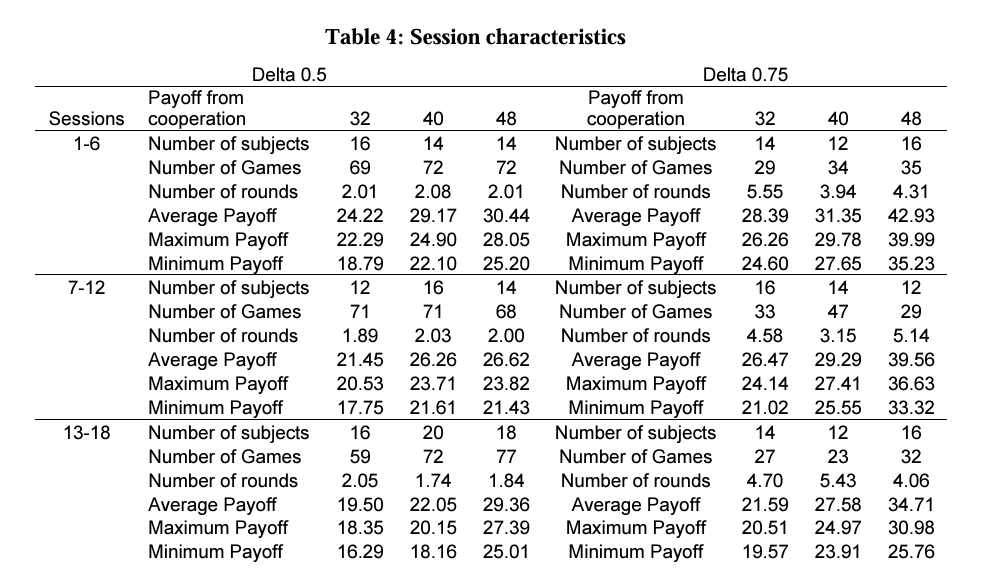

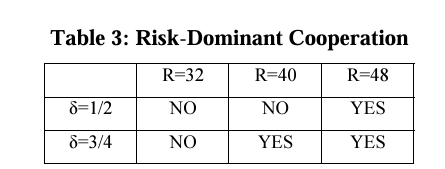

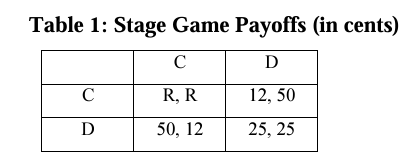

The Evolution of Cooperation in Infinitely Repeated Games: Experimental Evidence Pedro Dal Bó Brown University Guillaume R. Fréchette∗ New York University April 2007